# NLP to filter Email Spam

### Libraries

In [ ]:
import nltk
import pandas as pd
import numpy as np
import re
import string
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import time
# keras libraries
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping,TensorBoard

### Importing Data

In [2]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
lm = nltk.WordNetLemmatizer()
data = pd.read_csv("SMSSpamCollection.tsv", sep='\t')
data.columns = ['label', 'body_text']
data.head(10)

,label,body_text
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...
1,ham,"Nah I don't think he goes to usf, he lives aro..."
2,ham,Even my brother is not like to speak with me. ...
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!
4,ham,As per your request 'Melle Melle (Oru Minnamin...
5,spam,WINNER!! As a valued network customer you have...
6,spam,Had your mobile 11 months or more? U R entitle...
7,ham,I'm gonna be home soon and i don't want to tal...
8,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
9,spam,URGENT! You have won a 1 week FREE membership ...


### Label Encoding

In [4]:
#label encoder --- SPAM = 1, HAM = 0
label =LabelEncoder()
data['label'] = label.fit_transform(data['label'] )
data.head(10)

,label,body_text
0,1,Free entry in 2 a wkly comp to win FA Cup fina...
1,0,"Nah I don't think he goes to usf, he lives aro..."
2,0,Even my brother is not like to speak with me. ...
3,0,I HAVE A DATE ON SUNDAY WITH WILL!!
4,0,As per your request 'Melle Melle (Oru Minnamin...
5,1,WINNER!! As a valued network customer you have...
6,1,Had your mobile 11 months or more? U R entitle...
7,0,I'm gonna be home soon and i don't want to tal...
8,1,"SIX chances to win CASH! From 100 to 20,000 po..."
9,1,URGENT! You have won a 1 week FREE membership ...


### Feature generation
- Assuming that emails with more character ie Body length is more likely to be Spam
- Assuming that emails with proper english has higher punctuations and are more likely to be Ham.

In [5]:
# funtion to count number of punctuations in every emails
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

# calculating length of body excluding the spaces
data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))
data.head(10)

,label,body_text,body_len,punct%
0,1,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7
1,0,"Nah I don't think he goes to usf, he lives aro...",49,4.1
2,0,Even my brother is not like to speak with me. ...,62,3.2
3,0,I HAVE A DATE ON SUNDAY WITH WILL!!,28,7.1
4,0,As per your request 'Melle Melle (Oru Minnamin...,135,4.4
5,1,WINNER!! As a valued network customer you have...,132,4.5
6,1,Had your mobile 11 months or more? U R entitle...,126,1.6
7,0,I'm gonna be home soon and i don't want to tal...,89,6.7
8,1,"SIX chances to win CASH! From 100 to 20,000 po...",111,7.2
9,1,URGENT! You have won a 1 week FREE membership ...,130,6.2


- Visualizing the features generated to verify the hypothesis 
- Body length of Spam and Ham with overall distribution
- #Punctuations for Spam and Ham with overall distribution

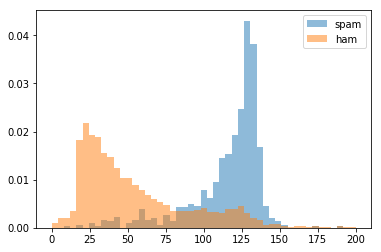

In [6]:
# Body length for Spam and Ham
bins = np.linspace(0, 200, 50)
pyplot.hist(data[data['label']==1]['body_len'], bins, alpha=0.5, normed=True, label='spam')
pyplot.hist(data[data['label']==0]['body_len'], bins, alpha=0.5, normed=True, label='ham')
pyplot.legend(loc='upper right')
pyplot.show()

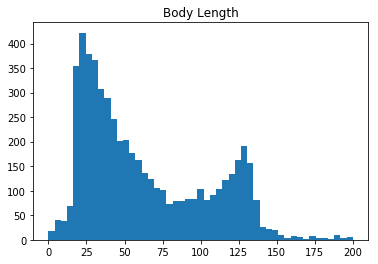

In [7]:
# overall body length distribution
pyplot.hist(data['body_len'], bins)
pyplot.title("Body Length")
pyplot.show()

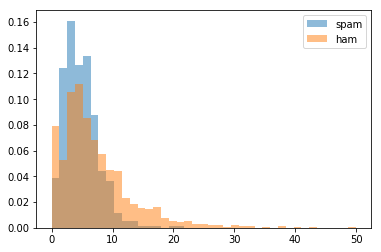

In [8]:
# punctuation % for Spam and Ham
bins = np.linspace(0, 50, 40)
pyplot.hist(data[data['label']==1]['punct%'], bins, alpha=0.5, normed=True, label='spam')
pyplot.hist(data[data['label']==0]['punct%'], bins, alpha=0.5, normed=True, label='ham')
pyplot.legend(loc='upper right')
pyplot.show()

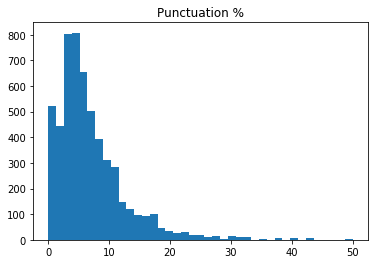

In [9]:
# overall punctutaion % distribution
pyplot.hist(data['punct%'], bins)
pyplot.title("Punctuation %")
pyplot.show()

### Scaling Features

In [10]:
#scaling
sc=MinMaxScaler(feature_range=(0,1)) 
data['body_len'] = sc.fit_transform(data.iloc[:,2:3])
data['punct%'] = sc.fit_transform(data.iloc[:,3:4])
data.head(10)

,label,body_text,body_len,punct%
0,1,Free entry in 2 a wkly comp to win FA Cup fina...,0.170732,0.047
1,0,"Nah I don't think he goes to usf, he lives aro...",0.063686,0.041
2,0,Even my brother is not like to speak with me. ...,0.081301,0.032
3,0,I HAVE A DATE ON SUNDAY WITH WILL!!,0.035230,0.071
4,0,As per your request 'Melle Melle (Oru Minnamin...,0.180217,0.044
5,1,WINNER!! As a valued network customer you have...,0.176152,0.045
6,1,Had your mobile 11 months or more? U R entitle...,0.168022,0.016
7,0,I'm gonna be home soon and i don't want to tal...,0.117886,0.067
8,1,"SIX chances to win CASH! From 100 to 20,000 po...",0.147696,0.072
9,1,URGENT! You have won a 1 week FREE membership ...,0.173442,0.062


### Cleaning the text by removing punctutaions, tokenizing and lemmatizing.

In [11]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [lm.lemmatize(word) for word in tokens if word not in stopwords]
    return text

### Train test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data[['body_text', 'body_len', 'punct%']], data['label'], test_size=0.2)
X1_train, X1_test, y1_train, y1_test = train_test_split(data[['body_text', 'body_len', 'punct%']], data['label'], test_size=0.2)

### Text Vectorization TF-IDF

In [13]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head(10)

,body_len,punct%,0,1,2,3,4,5,6,7,...,7847,7848,7849,7850,7851,7852,7853,7854,7855,7856
0,0.097561,0.027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.146341,0.073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.169377,0.063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.025745,0.095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.066396,0.039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.029810,0.083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.052846,0.049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.101626,0.104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.082656,0.032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.024390,0.100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Text Vectorization Count Vectorization

In [14]:
count_vect = CountVectorizer(analyzer=clean_text)
count_vect_fit = count_vect.fit(X1_train['body_text'])

cvf_train = count_vect_fit.transform(X1_train['body_text'])
cvf_test = count_vect_fit.transform(X1_test['body_text'])

X_cvfTrain_vect = pd.concat([X1_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(cvf_train.toarray())], axis=1)
X_cvfTest_vect = pd.concat([X1_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(cvf_test.toarray())], axis=1)

X_cvfTrain_vect.head(10)

,body_len,punct%,0,1,2,3,4,5,6,7,...,7763,7764,7765,7766,7767,7768,7769,7770,7771,7772
0,0.044715,0.086,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.172087,0.016,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.059621,0.043,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.172087,0.047,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.143631,0.037,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0.051491,0.100,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0.109756,0.036,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0.155827,0.077,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0.020325,0.118,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0.028455,0.130,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
